<a id="top_section"></a>
<div align='center'><font size="5" color="#000000"><b>Automatisation de la classification d’articles sur une marketplace e-commerce</b></font></div>
<hr>
<div align='center'><font size="4" color="#000000">Développement d'un moteur de classification basé sur les descriptions textuelles des produits</font></div>
<hr>

## Sommaire

- [**Introduction**](#Introduction)
    - [Contexte](#Contexte)
    - [Objectif du projet](#Objectif-du-projet)
- [**Importation des packages**](#Importation-des-packages)
- [**Exploration et préparation des données**](#Exploration-et-préparation-des-données)
    - [Chargement des données](#Chargement-des-données)
    - [Aperçu des données](#Aperçu-des-données)
    - [Création de la variable target](#Création-de-la-variable-target)
- [**Nettoyage des données textuelles**](#Nettoyage-des-données-textuelles)
    - [Tokenisation](#Tokenisation)
    - [Normalisation du texte](#Normalisation-du-texte)
    - [Suppression des stopwords](#Suppression-des-stopwords)
    - [Suppression des mots contenant des caractères numériques](#Suppression-des-mots-contenant-des-caractères-numériques)
    - [Suppression des mots rares](#Suppression-des-mots-rares)
    - [Suppression des mots fréquents](#Suppression-des-mots-fréquents)
    - [Lemmatisation ou Stemming](#Lemmatisation-ou-Stemming)
    - [Fonction de nettoyage](#Fonction-de-nettoyage)
    - [Nettoyage final](#Nettoyage-final)
- [**Vectorisation du texte**](#Vectorisation-du-texte)
    - [BoW](#BoW)
    - [TF-IDF](#TF-IDF)
    - [Word2Vec](#Word2Vec)
    - [BERT](#BERT)
    - [USE](#USE)
    - [Dictionnaire contenant toutes les vectorisations](#Dictionnaire-contenant-toutes-les-vectorisations)
- [**Modélisation**](#Modélisation)
    - [Entraînement et évaluation des modèles](#Entraînement-et-évaluation-des-modèles)
    - [Visualisation des résultats et sélection du modèle final](#Visualisation-des-résultats-et-sélection-du-modèle-final)
    - [Optimisation des hyperparamètres](#Optimisation-des-hyperparamètres)
    - [Interprétation des prédictions du modèle final](#Interprétation-des-prédictions-du-modèle-final)
- [**Conclusion**](#Conclusion)

## Introduction

### Contexte

Dans le cadre du développement d'une marketplace e-commerce, l'attribution de catégories d'articles est une tâche essentielle pour améliorer l'expérience utilisateur, que ce soit pour les vendeurs ou les acheteurs. Jusqu'à présent, les vendeurs attribuent manuellement une catégorie à chaque article qu'ils souhaitent mettre en ligne. Cependant, cette méthode est sujette à des erreurs et devient inefficace avec l'augmentation du volume d'articles.

### Objectif du projet

L’objectif de ce projet est de concevoir un moteur de classification automatique capable d'attribuer des catégories à des articles en se basant sur leurs descriptions textuelles. Ce moteur permettra de faciliter l'intégration de nouveaux produits par les vendeurs et d'améliorer la recherche des articles par les acheteurs.

## Importation des packages

In [1]:
# Imports principaux
import os
import numpy as np
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
import tensorflow_hub as hub
import tensorflow as tf
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# Modélisation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# Évaluation des modèles
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

## Exploration et préparation des données
### Chargement des données

In [2]:
df = pd.read_csv('data.csv')
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


### Aperçu des données

In [3]:
print("Dimensions du jeu de données :", df.shape)

Dimensions du jeu de données : (1050, 15)


Le jeu de données comprend 1 050 observations et 15 variables. Parmi celles-ci, trois variables sont particulièrement intéressantes pour notre projet :

- `product_category_tree` : Représente la catégorie du produit, qui servira de variable cible pour notre tâche de classification.
- `description` : Fournit une description textuelle détaillée du produit, à partir de laquelle nous allons extraire des informations pertinentes pour la classification.
- `image` : Contient le nom du fichier image associé à chaque produit. Nous intégrerons ces images dans un second temps pour enrichir notre modèle de classification.

In [4]:
df = df[['product_category_tree', 'description', 'image']]
df.head()

,product_category_tree,description,image
0,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_category_tree  1050 non-null   object
 1   description            1050 non-null   object
 2   image                  1050 non-null   object
dtypes: object(3)
memory usage: 24.7+ KB


Le jeu de données ne contient aucune valeur manquante.

In [6]:
# Nombre de classes uniques pour chaque variable catégorielle
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

product_category_tree     642
description              1050
image                    1050
dtype: int64

### Création de la variable target

Nous allons extraire la catégorie principale de chaque produit à partir de la variable `product_category_tree` afin de créer notre variable cible pour la classification :

In [7]:
# Fonction pour extraire la catégorie générale de la variable 'product_category_tree'
def extract_general_category(text):
    """
    Extrait la catégorie la plus générale à partir de la variable 'product_category_tree'.
    
    Cette fonction prend en entrée une chaîne de caractères représentant la hiérarchie des catégories d'un produit 
    (séparées par '>>') et retourne la catégorie la plus générale. Elle supprime également les caractères 
    indésirables tels que '[' et '"', ainsi que les espaces en trop autour du texte.

    Paramètres :
    ----------
    text : str
        Chaîne de caractères représentant la hiérarchie des catégories d'un produit (ex: "[\"Electronics >> Mobiles >> Smartphones\"]").

    Retourne :
    -------
    str
        La catégorie la plus générale du produit (ex: "Home Furnishing").
    """
    # Diviser la chaîne en sous-catégories en utilisant '>>' comme séparateur
    parts = text.split(">>")
    
    # Vérifier si la liste des parties n'est pas vide et extraire la première catégorie
    if len(parts) > 0:
        general_category = parts[0].strip()  # Supprimer les espaces en trop autour du texte
        general_category = general_category.replace('[', '').replace('"', '')  # Supprimer les caractères indésirables '[' et '"'
        return general_category
    else:
        # Si la chaîne ne contient pas '>>', retourner le texte original
        return text

In [8]:
# Application de la fonction
df['target'] = df['product_category_tree'].apply(extract_general_category)

# Suppression de la colonne 'product_category_tree' qui ne nous sera plus utile
df = df.drop(columns='product_category_tree')

df.head()

,description,image,target
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


Observons plus en détail la variable cible :

In [9]:
# Nombre d'observations par classe
df['target'].value_counts()

target
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

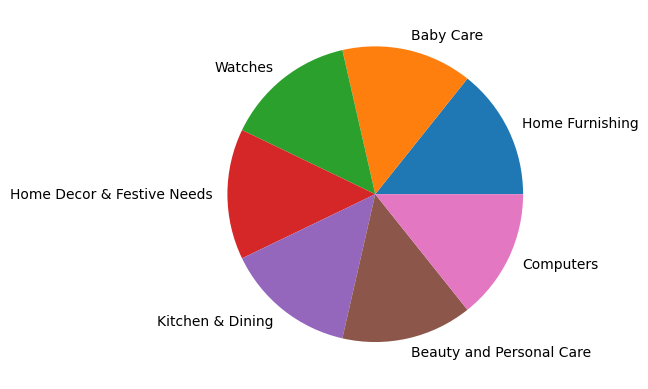

In [10]:
df.target.value_counts().plot(kind="pie")
plt.ylabel('')
plt.show()

On peut observer que chaque catégorie est composée de 150 produits.

## Nettoyage des données textuelles

Dans cette partie, nous allons nettoyer les données textuelles contenues dans la variable `description`.

In [11]:
corpus = "".join(df.description.values)
corpus[:1000]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

### Tokenisation
Commençons séparé notre texte en unité de mots (tokens) :

In [12]:
tokenizer = RegexpTokenizer(r"\w+") # Suppression de la ponctuation
tokens = tokenizer.tokenize(corpus)

Développement d'une fonction d'affichage du nombre de tokens :

In [13]:
def display_tokens_info(tokens):
    """
    Affiche des informations sur le corpus de tokens.

    Args:
        tokens (list): Une liste de tokens.

    """
    # Calcul du nombre de tokens et du nombre de tokens uniques
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    
    # Affichage des informations
    print(f"Nombre de tokens : {num_tokens}\nNombre de tokens uniques : {num_unique_tokens}")

In [14]:
display_tokens_info(tokens)

Nombre de tokens : 81219
Nombre de tokens uniques : 7873


### Normalisation du texte
Conversion en minuscules pour éviter les doublons :

In [15]:
tokens = [token.lower() for token in tokens]
print(tokens[:10])

['key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain']


In [16]:
display_tokens_info(tokens)

Nombre de tokens : 81219
Nombre de tokens uniques : 6284


### Suppression des stopwords
Les stopwords sont les mots très courants dans la langue étudiée ("et", "à", "le"... en français) qui **n'apportent pas de valeur informative** pour la compréhension du "sens" d'un document et corpus.

In [17]:
# Liste de stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'hers', "haven't", 'our', 'him', 'after', 'in', 'y', 'weren', 'be', 'again', 'very', 'wasn', 'there', 'before', 'she', 't', 'them', 'was', "don't", 'no', 'her', 'me', 'it', "needn't", 'itself', 'will', "hadn't", 'those', 'doing', 'ain', "doesn't", "shan't", "you've", 'herself', "that'll", 'its', 'too', 'don', 'whom', 'about', 'same', 'each', 'any', 'these', 'can', 'does', 'own', 'how', 'yourselves', 'has', 'some', 'so', 'were', 'during', 'to', 'do', 'an', 'your', 'such', 'hasn', 'd', 'further', "you'll", "should've", 'if', 'between', 'the', 'through', 'aren', 'mustn', 'most', 'having', 'that', 'did', 'yours', 'from', 'mightn', 'down', 'needn', 'being', "hasn't", 'when', 'theirs', 'yourself', 'where', "didn't", "wouldn't", "it's", "isn't", 'ma', 'o', 'once', 'at', 'not', "shouldn't", 'his', 'couldn', "you'd", 'below', "mightn't", 'nor', 'been', 'won', 'only', "aren't", 'or', "mustn't", 'until', 'they', 'because', 'he', "weren't", 'isn', 'shan', 'why', 'more', "you're", 'll', 'both', 'i

In [18]:
tokens = [token for token in tokens if token not in stop_words]
display_tokens_info(tokens)

Nombre de tokens : 61452
Nombre de tokens uniques : 6165


### Suppression des mots contenant des caractères numériques
Les mots contenant des caractères numériques n'apportent généralement pas de valeur sémantique utile à l'analyse textuelle.

In [19]:
tmp = [''.join([w for w in token if not any(char.isdigit() for char in w)]) for token in tokens]
tokens = [w for w in tmp if w in tokens]
display_tokens_info(tokens)

Nombre de tokens : 55723
Nombre de tokens uniques : 5082


### Suppression des mots rares
Les mots rares peuvent souvent être du bruit, c'est-à-dire des termes peu informatifs ou des erreurs dans le texte (fautes de frappe, termes mal orthographiés, etc.). Nous allons donc supprimer les mots qui n'apparaissent qu'une seule fois :

In [20]:
tmp = pd.Series(tokens).value_counts()
list_unique_words = list(tmp[tmp==1].index)
print(f"Nombre de tokens qui n'apparaissent qu'une seule fois sur l'ensemble du corpus : {len(list_unique_words)}")

Nombre de tokens qui n'apparaissent qu'une seule fois sur l'ensemble du corpus : 1584


In [21]:
tokens = [token for token in tokens if token not in list_unique_words]
display_tokens_info(tokens)

Nombre de tokens : 54139
Nombre de tokens uniques : 3498


### Suppression des mots fréquents
Tout comme les stopwords, les mots fréquents du corpus n'apportent pas de valeur informative pour la compréhension de son sens.

In [22]:
tmp.head(30)

rs                911
products          631
free              618
delivery          567
shipping          564
cash              564
genuine           564
replacement       559
buy               547
cm                541
day               540
flipkart          476
guarantee         471
com               468
online            396
features          395
price             352
watch             329
color             328
baby              320
mug               318
pack              317
material          312
set               307
specifications    305
type              304
cotton            299
box               291
general           288
package           269
Name: count, dtype: int64

Nous allons supprimer les mots dont l'occurence dépasse 250 car il s'agit de mots génériques qui ne vont pas nous aider à différencier la catégorie des produits.

In [23]:
list_common_words = list(tmp[tmp>250].index)
print(f"Nombre de tokens qui apparaissent plus de 250 fois sur l'ensemble du corpus : {len(list_common_words)}")

Nombre de tokens qui apparaissent plus de 250 fois sur l'ensemble du corpus : 33


In [24]:
print(list_common_words)

['rs', 'products', 'free', 'delivery', 'shipping', 'cash', 'genuine', 'replacement', 'buy', 'cm', 'day', 'flipkart', 'guarantee', 'com', 'online', 'features', 'price', 'watch', 'color', 'baby', 'mug', 'pack', 'material', 'set', 'specifications', 'type', 'cotton', 'box', 'general', 'package', 'analog', 'sales', 'number']


Nous allons conserver les mots 'watch', 'baby', 'mug', 'cotton' et 'analog' qui peuvent potentiellement être utiles au modèle.

In [25]:
words = ['watch','baby','mug','cotton','analog']

for w in words:
    list_common_words.remove(w)

print(list_common_words)

['rs', 'products', 'free', 'delivery', 'shipping', 'cash', 'genuine', 'replacement', 'buy', 'cm', 'day', 'flipkart', 'guarantee', 'com', 'online', 'features', 'price', 'color', 'pack', 'material', 'set', 'specifications', 'type', 'box', 'general', 'package', 'sales', 'number']


Suppression des mots fréquents :

In [26]:
tokens = [token for token in tokens if token not in list_common_words]
display_tokens_info(tokens)

Nombre de tokens : 41740
Nombre de tokens uniques : 3470


### Lemmatisation ou Stemming

La lemmatisation et le stemming sont des techniques qui visent à réduire les variations d’un mot à une forme de base, ce qui permet de normaliser les termes et de simplifier l'analyse. Cependant, ces deux techniques diffèrent dans la manière dont elles fonctionnent :

**La lemmatisation** consiste à ramener un mot à sa forme canonique ou à son lemme, c'est-à-dire sa forme de base ou son infinitif (pour un verbe). Contrairement au stemming, la lemmatisation prend en compte le contexte et les règles linguistiques pour identifier la forme correcte d’un mot.

**Le stemming** est une approche plus simple et plus agressive. Il consiste à trancher ou à couper les suffixes et préfixes des mots pour en obtenir la racine (ou stem). Cela ne prend pas en compte la forme correcte du mot dans la langue, et se contente de retirer les terminaisons pour obtenir une racine approximative.

Ces deux techniques ont donc des impacts différents sur la manière dont les mots sont représentés. Selon la nature du corpus et le modèle utilisé (par exemple, un modèle de classification comme une régression logistique, un SVM, ou un réseau de neurones), l'une de ces techniques pourrait offrir de meilleurs résultats en termes de performance du modèle. Nous allons donc tester ces deux méthodes et sélectionner celle qui permet d'obtenir les meilleures performances de classification.

In [27]:
# Lemmatisation
wordNetLemmatizer = WordNetLemmatizer()
lem_tokens = [wordNetLemmatizer.lemmatize(token) for token in tokens]
display_tokens_info(lem_tokens)

Nombre de tokens : 41740
Nombre de tokens uniques : 3202


In [28]:
# Stemming
porterStemmer = PorterStemmer()
stem_tokens = [porterStemmer.stem(token) for token in tokens]
display_tokens_info(stem_tokens)

Nombre de tokens : 41740
Nombre de tokens uniques : 2859


Les étapes de nettoyage ont permis de réduire le corpus de 81 219 tokens (dont 7 873 uniques) à un corpus plus compact de 41 740 tokens. Après le traitement, le corpus lemmatisé contient 3 202 tokens uniques, tandis que le corpus stemmé en contient 2 859. Cela montre une réduction significative du nombre de termes, facilitant l’analyse tout en préservant le sens du contenu.

### Fonction de nettoyage

In [29]:
def clean_corpus(doc, rejoin=False, lem_or_stem="lem", list_rare_words=None, list_common_words=None):
    """
    Fonction de nettoyage des données textuelles.

    Paramètres :
        doc (str): Le document texte à nettoyer.
        rejoin (bool, optional): Indique si les tokens nettoyés doivent être rejoints en une chaîne de caractères. 
                                 Par défaut, False.
        lem_or_stem (str, optional): Indique si la lemmatisation ('lem') ou le stemming ('stem') doit être appliqué.
                                     Par défaut, 'lem'.
        list_rare_words (list, optional): Liste de mots rares à supprimer. Par défaut, None.
        list_common_words (list, optional): Liste de mots courants à supprimer. Par défaut, None.

    Retourne :
        list/str: Une liste de tokens nettoyés si `rejoin` est False, sinon une chaîne de caractères.

    """   
    # Tokenisation
    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(doc)
    
    # Conversion en minuscules
    tokens = [token.lower() for token in tokens]
    
    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Suppression des mots contenant des caractères numériques
    tmp = [''.join([w for w in token if not any(char.isdigit() for char in w)]) for token in tokens]
    tokens = [w for w in tmp if w in tokens]
    
    # Suppression des mots rares
    tokens = [token for token in tokens if token not in list_rare_words]
    
    # Suppression des mots fréquents
    tokens = [token for token in tokens if token not in list_common_words]
    
    # Application de la lemmatization ou du stemming
    if lem_or_stem == "lem":
        lemmaWords = WordNetLemmatizer()
        tokens = [lemmaWords.lemmatize(token) for token in tokens]
    elif lem_or_stem == "stem":
        stemWords = PorterStemmer()
        tokens = [stemWords.stem(token) for token in tokens]
    else:
        raise ValueError("Please specify 'lem' or 'stem' for the lem_or_stem argument.")
    
    # Rejoindre les tokens si nécessaire
    if rejoin:
        return " ".join(tokens)
    
    return tokens

### Nettoyage final
Nous allons procéder au nettoyage final de chaque description de produit en créant deux nouvelles colonnes dans le dataframe : l'une avec la lemmatisation et l'autre avec le stemming.

In [30]:
df["clean_description_lem"] = df.description.apply(
    lambda doc: clean_corpus(
        doc,
        rejoin=True,
        lem_or_stem="lem",
        list_rare_words=list_unique_words,
        list_common_words=list_common_words
    )
)

In [31]:
df["clean_description_stem"] = df.description.apply(
    lambda doc: clean_corpus(
        doc,
        rejoin=True,
        lem_or_stem="stem",
        list_rare_words=list_unique_words,
        list_common_words=list_common_words
    )
)

In [32]:
df.head()

,description,image,target,clean_description_lem,clean_description_stem
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,key elegance polyester multicolor abstract eye...,key eleg polyest multicolor abstract eyelet do...
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,sathiyas cotton bath towel bath towel red yell...,sathiya cotton bath towel bath towel red yello...
2,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,key eurospa cotton terry face towel size small...,key eurospa cotton terri face towel size small...
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,key santosh royal fashion cotton printed king ...,key santosh royal fashion cotton print king si...
4,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,key jaipur print cotton floral king sized doub...,key jaipur print cotton floral king size doubl...


### Séparation de la variable cible des variables prédictives 

In [33]:
y = df['target']

# Jeu de données nettoyé avec la lemmatisation
X_lem = df['clean_description_lem']

# Jeu de données nettoyé avec le stemming
X_stem = df['clean_description_stem']

### Séparation des données en deux ensembles : entraînement et test

In [34]:
X_train_lem, X_test_lem, y_train, y_test = train_test_split(X_lem, y, test_size=0.25, random_state=42)

# Obtenir les indices de train et de test
train_indices = X_train_lem.index
test_indices = X_test_lem.index

# Appliquer ces indices à X_stem
X_train_stem = X_stem.loc[train_indices]
X_test_stem = X_stem.loc[test_indices]

Encodage de la variable cible :

In [35]:
# Instancier l'encodeur
label_encoder = LabelEncoder()

# Appliquer l'encodeur sur y_train et y_test
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

## Vectorisation du texte
### Bag of Words
Jeu de données nettoyé avec la lemmatisation :

In [36]:
# Initialiser le vectoriseur BoW
bow_vectorizer = CountVectorizer()

# Appliquer la vectorisation BoW
X_train_lem_bow = bow_vectorizer.fit_transform(X_train_lem)
X_test_lem_bow = bow_vectorizer.transform(X_test_lem)

Jeu de données nettoyé avec le stemming :

In [37]:
# Initialiser le vectoriseur BoW
bow_vectorizer = CountVectorizer()

# Appliquer la vectorisation BoW
X_train_stem_bow = bow_vectorizer.fit_transform(X_train_stem)
X_test_stem_bow = bow_vectorizer.transform(X_test_stem)

### TF-IDF
Jeu de données nettoyé avec la lemmatisation :

In [38]:
# Initialiser le vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Appliquer la vectorisation TF-IDF
X_train_lem_tfidf = tfidf_vectorizer.fit_transform(X_train_lem)
X_test_lem_tfidf = tfidf_vectorizer.transform(X_test_lem)

Jeu de données nettoyé avec le stemming :

In [39]:
# Initialiser le vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Appliquer la vectorisation TF-IDF
X_train_stem_tfidf = tfidf_vectorizer.fit_transform(X_train_stem)
X_test_stem_tfidf = tfidf_vectorizer.transform(X_test_stem)

### Word2Vec

Word2Vec est un algorithme d'apprentissage non supervisé utilisé pour apprendre des représentations vectorielles de mots à partir de grands corpus de textes. L'idée principale de Word2Vec est de représenter chaque mot dans un espace vectoriel de manière à capturer ses relations sémantiques avec d'autres mots.

Word2Vec génère des représentations vectorielles de mots en basant l'entraînement sur le contexte dans lequel les mots apparaissent : le modèle prend un mot central et essaie de prédire les mots qui l'entourent dans une fenêtre de contexte donnée.

Paramètres principaux de l'algorithme :
- `vector_size` : La dimension des vecteurs de mots (par exemple, 100 ou 300).
- `window` : La taille de la fenêtre de contexte (nombre de mots avant et après le mot central).
- `min_count` : Ignore les mots qui apparaissent moins que ce nombre dans le corpus.

Jeu de données nettoyé avec la lemmatisation :

In [40]:
# Tokeniser les phrases en mots
X_train_lem_tokens = [sentence.split() for sentence in X_train_lem]
X_test_lem_tokens = [sentence.split() for sentence in X_test_lem]

# Entraîner Word2Vec
w2v_model = Word2Vec(sentences=X_train_lem_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Moyenne des vecteurs Word2Vec pour chaque phrase
def get_w2v_vectors(model, tokens):
    return np.array([np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(100)], axis=0) for words in tokens])

# Appliquer la vectorisation Word2Vec
X_train_lem_w2v = get_w2v_vectors(w2v_model, X_train_lem_tokens)
X_test_lem_w2v = get_w2v_vectors(w2v_model, X_test_lem_tokens)

Jeu de données nettoyé avec le stemming :

In [41]:
# Tokeniser les phrases en mots
X_train_stem_tokens = [sentence.split() for sentence in X_train_stem]
X_test_stem_tokens = [sentence.split() for sentence in X_test_stem]

# Entraîner Word2Vec
w2v_model = Word2Vec(sentences=X_train_stem_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Appliquer la vectorisation Word2Vec
X_train_stem_w2v = get_w2v_vectors(w2v_model, X_train_stem_tokens)
X_test_stem_w2v = get_w2v_vectors(w2v_model, X_test_stem_tokens)

### BERT
BERT (Bidirectional Encoder Representations from Transformers) est un modèle de traitement du langage naturel basé sur l'architecture Transformer. Il est entraîné pour capturer le contexte d'un mot en tenant compte de son environnement dans les deux directions (avant et arrière). Contrairement aux modèles comme Word2Vec où chaque mot a une seule représentation fixe, BERT est bidirectionnel, ce qui lui permet d'avoir une représentation dynamique qui change selon la signification du mot dans une phrase donnée.

BERT est pré-entraîné sur deux tâches :
- Masked Language Model : BERT masque certains mots d'une phrase et doit les prédire en fonction du contexte.
- Next Sentence Prediction : BERT est aussi entraîné pour prédire si une phrase suit logiquement une autre, ce qui l'aide à comprendre les relations entre phrases.

Ensuite, BERT peut être fine-tuné sur des tâches spécifiques telles que la classification de texte.

Ici, nous allons utiliser DistilBERT, une version plus légère de BERT qui permet de gagner en temps de calcul. Ce modèle nous servira à extraire les représentations vectorielles des mots.

Jeu de données nettoyé avec la lemmatisation :

In [42]:
# Charger le tokenizer et le modèle DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Fonction pour obtenir les embeddings DistilBERT (représentations vectorielles)
def get_distilbert_embeddings(texts):
    # Tokeniser les textes
    tokens = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    # Désactiver la dérivation des gradients car nous n'avons pas besoin d'entraîner le modèle ici
    with torch.no_grad():
        outputs = model(**tokens)
    # Prendre la moyenne des vecteurs de sortie pour obtenir une représentation globale de la phrase
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Appliquer la fonction pour obtenir les embeddings sur les ensembles d'entraînement et de test
X_train_lem_bert = [get_distilbert_embeddings(text) for text in X_train_lem]
X_test_lem_bert = [get_distilbert_embeddings(text) for text in X_test_lem]

# Suppression de la dimension inutile
X_train_lem_bert = np.squeeze(X_train_lem_bert, axis=1)
X_test_lem_bert = np.squeeze(X_test_lem_bert, axis=1)

Jeu de données nettoyé avec le stemming :

In [43]:
X_train_stem_bert = [get_distilbert_embeddings(text) for text in X_train_stem]
X_test_stem_bert = [get_distilbert_embeddings(text) for text in X_test_stem]

# Suppression de la dimension inutile
X_train_stem_bert = np.squeeze(X_train_stem_bert, axis=1)
X_test_stem_bert = np.squeeze(X_test_stem_bert, axis=1)

### USE

USE (Universal Sentence Encoder) est un modèle de machine learning conçu pour générer des représentations vectorielles de phrases ou de documents entiers, permettant de capturer leur sens global. 

Il existe en deux versions : une basée sur un réseau Transformer, qui utilise un mécanisme d'attention pour comprendre les relations complexes entre les mots, et une autre basée sur un réseau Deep Averaging Network (DAN), qui fait la moyenne des embeddings de mots pour obtenir une représentation moins coûteuse en calcul. Le modèle est pré-entraîné sur de grandes quantités de données pour capturer un large éventail de relations sémantiques.

USE produit un vecteur de 512 dimensions pour chaque phrase, ce qui permet de mesurer la similarité sémantique entre phrases, indépendamment des mots exacts utilisés. Ce modèle peut être utilisé pour des tâches comme la recherche sémantique, la classification de texte et la détection de similarité.

In [44]:
# Configurer TensorFlow pour ignorer les avertissements
tf.get_logger().setLevel('ERROR')

In [45]:
# Charger le modèle Universal Sentence Encoder version Transformer
os.environ['TFHUB_CACHE_DIR'] = '/home/user/workspace/tf_cache'
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Appliquer la vectorisation USE
X_train_lem_use = embed(X_train_lem)
X_test_lem_use = embed(X_test_lem)

Jeu de données nettoyé avec le stemming :

In [46]:
X_train_stem_use = embed(X_train_stem)
X_test_stem_use = embed(X_test_stem)

### Dictionnaire contenant toutes les vectorisations

In [47]:
# Jeux de données de vectorisation
datasets = {
    "lem_bow": (X_train_lem_bow, X_test_lem_bow),
    "stem_bow": (X_train_stem_bow, X_test_stem_bow),
    "lem_tfidf": (X_train_lem_tfidf, X_test_lem_tfidf),
    "stem_tfidf": (X_train_stem_tfidf, X_test_stem_tfidf),
    "lem_w2v": (X_train_lem_w2v, X_test_lem_w2v),
    "stem_w2v": (X_train_stem_w2v, X_test_stem_w2v),
    "lem_bert": (X_train_lem_bert, X_test_lem_bert),
    "stem_bert": (X_train_stem_bert, X_test_stem_bert),
    "lem_use": (X_train_lem_use, X_test_lem_use),
    "stem_use": (X_train_stem_use, X_test_stem_use)
}

## Modélisation
### Entraînement et évaluation des modèles

In [48]:
# Dictionnaire contenant les modèles de machine learning à tester
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Linear SVM": SVC(kernel='linear', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Kernel SVM": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Multilayer Perceptron": MLPClassifier(max_iter=1000, random_state=42)
}

In [49]:
results = []

# Boucle sur chaque dataset et modèle
for dataset_name, (X_train, X_test) in datasets.items():
    for model_name, model in models.items():
        # Entraînement du modèle
        trained_model = model.fit(X_train, y_train)
        
        # Prédiction sur les données de test
        y_pred = trained_model.predict(X_test)
        
        # Calcul des métriques de performance
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted')
        
        # Stocker les résultats
        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall
        })

# Convertion des résultats en DataFrame
results_df = pd.DataFrame(results)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Visualisation des résultats et sélection du modèle final

Création d'une heatmap affichant l'accuracy pour chaque modèle et type de vectorisation :

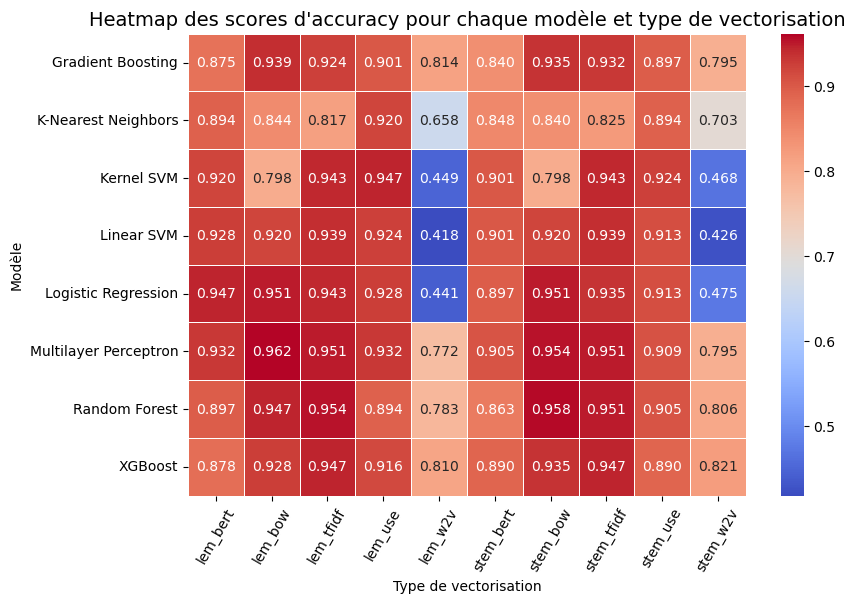

In [50]:
# Création d'une matrice contenant les scores accuracy avec les modèles en lignes et les datasets en colonnes
accuracy_matrix = results_df.pivot(index='Model', columns='Dataset', values='Accuracy')

# Création d'une heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(accuracy_matrix, annot=True, fmt=".3f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title("Heatmap des scores d'accuracy pour chaque modèle et type de vectorisation", fontsize=14)
plt.xlabel("Type de vectorisation")
plt.ylabel("Modèle")
plt.xticks(rotation=60)
plt.show()

Le modèle MLPClassifier semble offrir les meilleures performances en termes d'accuracy sur le jeu de données lemmatisé et vectorisé à l'aide de la méthode Bag of Words.

Ce modèle est un algorithme de classification qui utilise des couches de neurones fully-connected. Chaque neurone dans une couche est connecté à tous les neurones de la couche précédente, permettant au modèle d'apprendre des relations complexes non linéaires à l'aide d'une fonction d'activation.

Nous allons donc retenir le modèle MLPClassifier comme modèle final et procéder à l'optimisation de ses hyperparamètres, afin d'améliorer encore ses performances sur ce jeu de données.

### Optimisation des hyperparamètres

Afin d'identifier les hyperparamètres permettant de maximiser les performances des modèles, nous allons utiliser RandomizedSearchCV qui teste aléatoirement plusieurs combinaisons possibles.

In [51]:
# Sélection du modèle et du jeu de données permettant d'obtenir les meilleures performances
mlp = models['Multilayer Perceptron']
X_train, X_test = datasets['lem_bow']

In [52]:
# Grille de paramètres à tester
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)], # Nombre et taille des couches cachées
    'activation': ['relu', 'tanh'], # Fonction d'activation utilisée dans les neurones
    'solver': ['adam', 'sgd'], # Algorithme d'optimisation
    'alpha': [0.0001, 0.001, 0.01], # Terme de régularisation L2
    'learning_rate_init': [0.001, 0.01, 0.1], # Taux d'apprentissage initial pour la mise à jour des poids
}

# Configuration de RandomizedSearchCV
random_search = RandomizedSearchCV(
    mlp,
    param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)

# Recherche des meilleurs hyperparamètres sur le jeu de données
search_result = random_search.fit(X_train, y_train)

# Affichage des résultats de l'optimisation
print(f"Meilleurs hyperparamètres : {search_result.best_params_}")

C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


Meilleurs hyperparamètres : {'solver': 'sgd', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'tanh'}


In [53]:
# Réentraînement du modèle avec les meilleurs hyperparamètres trouvés
final_model = search_result.best_estimator_.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = final_model.predict(X_test)
        
# Affichage du scure d'accuracy
print(f"Accuracy du modèle final : {round(accuracy_score(y_test, y_pred), 3)}")

Accuracy du modèle final : 0.962


### Interprétation des prédictions du modèle final

Affichons la matrice de confusion des prédictions du modèle final :

In [54]:
# Récupération des labels non encodés
y_test_lab = label_encoder.inverse_transform(y_test)
y_pred_lab = label_encoder.inverse_transform(y_pred)

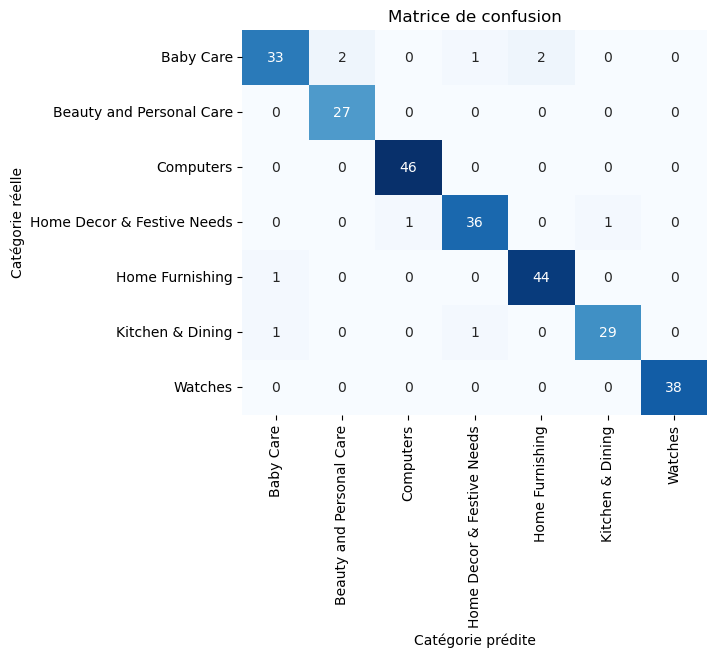

In [55]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test_lab, y_pred_lab, labels=label_encoder.classes_)

# Affichage de la figure
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar=False)
plt.title(f'Matrice de confusion')
plt.xlabel('Catégorie prédite')
plt.ylabel('Catégorie réelle')
plt.show()

In [56]:
print(classification_report(y_test_lab, y_pred_lab))

                            precision    recall  f1-score   support

                 Baby Care       0.94      0.87      0.90        38
  Beauty and Personal Care       0.93      1.00      0.96        27
                 Computers       0.98      1.00      0.99        46
Home Decor & Festive Needs       0.95      0.95      0.95        38
           Home Furnishing       0.96      0.98      0.97        45
          Kitchen & Dining       0.97      0.94      0.95        31
                   Watches       1.00      1.00      1.00        38

                  accuracy                           0.96       263
                 macro avg       0.96      0.96      0.96       263
              weighted avg       0.96      0.96      0.96       263



- Le modèle parvient à classer parfaitement les acticles de la catégorie `Watches`, comme le montre le score d'accuracy de 1,00.
- Pour les catégories `Computers`, `Home Decor & Festive Needs`, `Home Furnishing` et `Kitchen & Dining`, les scores d'accuracy, tous supérieurs ou égaux à 0,95, témoignent d'une classification très fiable.
- Enfin, le modèle rencontre plus de difficultés à classer précisément les articles des catégories `Baby Care` et `Beauty and Personal Care`, où les scores d'accuracy de 0,93 et 0,94 indiquent une marge d'amélioration.

## Conclusion

Dans le cadre de ce projet, nous avons développé un moteur de classification automatique pour l'attribution de catégories à des articles d'une marketplace e-commerce. Grâce à une approche systématique incluant l'exploration, le nettoyage, et la vectorisation des données textuelles, nous avons pu créer un modèle performant capable de classer les articles avec une grande précision.

L'utilisation du modèle MLPClassifier a montré des résultats particulièrement encourageants, atteignant une accuracy de 0.962 sur le jeu de données lemmatisé et vectorisé à l'aide de la méthode Bag of Words.

En intégrant ce modèle dans la plateforme e-commerce, il sera alors possible de réduire les erreurs humaines, améliorer l'expérience utilisateur tant pour les vendeurs que pour les acheteurs, et faciliter la recherche d'articles.